In [1]:
import pandas as pd

species = pd.read_csv("species_info.csv")
observations = pd.read_csv("observations.csv")

print(species.shape, observations.shape)
species.head()


(5824, 4) (23296, 3)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [2]:
species.info()
observations.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


# Project Scope — Biodiversity (Codecademy)

## 1) Project Goals
**Primary question(s):**
- Which species categories (Mammal, Bird, Reptile, etc.) show the highest share of protected species?
- Are some parks concentrating a larger number of protected species observations than others?
- What actionable recommendation can we make to park management (e.g., where to focus conservation efforts)?

**Success criteria (definition of done):**
- 3–5 clear plots + 2–3 concise summary tables.
- Short written summary (≈ 300–500 words) answering the primary questions.
- Reproducible notebook; repo contains notebook + data + README.

## 2) Data
**Files:**
- `species_info.csv` — species-level info: `category`, `scientific_name`, `common_names`, `conservation_status` (missing = no intervention).
- `observations.csv` — observed counts by park & species: `park_name`, `scientific_name`, `observations`.

**Assumptions & notes:**
- Species names are unique by `scientific_name`; common names may contain multiple names.
- Missing `conservation_status` will be treated as `"No Intervention"`.
- Observations are counts (not rates) and may reflect sampling effort differences across parks.

## 3) Analysis Plan
**A. Load & clean**
- Read both CSVs.
- Deduplicate rows in `species_info` by `scientific_name` if needed.
- Create `is_protected = conservation_status != "No Intervention"` (after filling NaNs).
- (Optional) Normalize `common_names` to lowercase for keyword filtering.

**B. Core EDA**
- Count unique species overall and by `category`.
- Frequency of `conservation_status` (including %).
- Pivot: `category` × `is_protected` (counts & %).

**C. Park-level analysis**
- Join `observations` ↔ `species_info` on `scientific_name`.
- Sum protected vs. not protected observations by `park_name`.
- Rank parks by protected observations (absolute and % of all observations).

**D. Focus question (optional extension)**
- Case study: mammals containing the word “Sheep” in `common_names` **and** `category == "Mammal"`.
- Compare observation totals/rates across parks; discuss conservation implications.
  - Use regex word boundary for robust match: `r"\bSheep\b"`.

**E. (Optional) Statistical test**
- Chi-squared test for association between `category` and `is_protected`.

## 4) Outputs
- Plots:
  - Bar chart: count of species by `conservation_status`.
  - Stacked/clustered bar: protected vs. not by `category`.
  - Bar chart: protected observations by `park_name` (top parks).
- Tables:
  - `category` × `is_protected` (counts, percentages).
  - Park summary: total observations, protected observations, protected share.
- Written summary (findings + recommendation).
- `README` with instructions to run the analysis.

## 5) Evaluation & Risks
- **Data quality:** duplicated scientific names, ambiguous common names (false positives like “Sheep sorrel” — plant). Mitigation: filter by category when keyword-matching; use regex word boundary.
- **Sampling bias:** different observation effort by park. Mitigation: report both absolute counts and shares.
- **Missing statuses:** treat NaN as `"No Intervention"` and clearly state this choice.

## 6) Timeline & Checklist
- [ ] Load & sanity-check data (shapes, columns, head).
- [ ] Clean + `is_protected`.
- [ ] Core EDA + plots.
- [ ] Park-level join + plots.
- [ ] (Optional) Sheep case study + chi-squared.
- [ ] Write summary.
- [ ] Update README and push to GitHub.

## 7) Version Control
- Commit at each milestone:
  - "Add project scope"
  - "Load and clean data"
  - "EDA: status/category"
  - "Park-level analysis"
  - "Summary & README"


In [3]:
import pandas as pd

species = pd.read_csv("species_info.csv")
observations = pd.read_csv("observations.csv")

print("species:", species.shape)
print("observations:", observations.shape)
species.head()


species: (5824, 4)
observations: (23296, 3)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [4]:
import pandas as pd

species = pd.read_csv("species_info.csv")
observations = pd.read_csv("observations.csv")

species["conservation_status"] = species["conservation_status"].fillna("No Intervention")
species["is_protected"] = species["conservation_status"] != "No Intervention"

species["conservation_status"].value_counts(), species["is_protected"].value_counts()


(conservation_status
 No Intervention       5633
 Species of Concern     161
 Endangered              16
 Threatened              10
 In Recovery              4
 Name: count, dtype: int64,
 is_protected
 False    5633
 True      191
 Name: count, dtype: int64)

In [5]:
cat_prot = (species.groupby(["category","is_protected"])["scientific_name"]
                    .nunique().unstack(fill_value=0))
cat_prot["protected_share"] = (cat_prot[True] / (cat_prot[True] + cat_prot[False])).round(3)
cat_prot.sort_values("protected_share", ascending=False)


is_protected,False,True,protected_share
category,,,
Mammal,146,30,0.170
Bird,413,75,0.154
Amphibian,72,7,0.089
Fish,115,11,0.087
Reptile,73,5,0.064
Nonvascular Plant,328,5,0.015
Vascular Plant,4216,46,0.011


In [6]:
import pandas as pd

# jeśli masz już w pamięci, możesz pominąć te dwie linie
species = pd.read_csv("species_info.csv")
observations = pd.read_csv("observations.csv")

species["conservation_status"] = species["conservation_status"].fillna("No Intervention")
species["is_protected"] = species["conservation_status"] != "No Intervention"

obs = observations.merge(
    species[["scientific_name", "is_protected", "category"]],
    on="scientific_name",
    how="left"
)

# sanity check
obs["is_protected"].isna().sum(), obs.shape


(np.int64(0), (25632, 5))

In [7]:
park_summary = (obs.groupby(["park_name","is_protected"])["observations"]
                  .sum().unstack(fill_value=0))
park_summary["total"] = park_summary[True] + park_summary[False]
park_summary["protected_share"] = (park_summary[True] / park_summary["total"]).round(3)

# parki z najwyższym udziałem chronionych obserwacji
park_summary.sort_values(["protected_share","total"], ascending=[False, False]).head(10)


is_protected,False,True,total,protected_share
park_name,,,,
Bryce National Park,614682,18609,633291,0.029
Yellowstone National Park,1543058,44583,1587641,0.028
Yosemite National Park,922539,26913,949452,0.028
Great Smoky Mountains National Park,462047,12816,474863,0.027


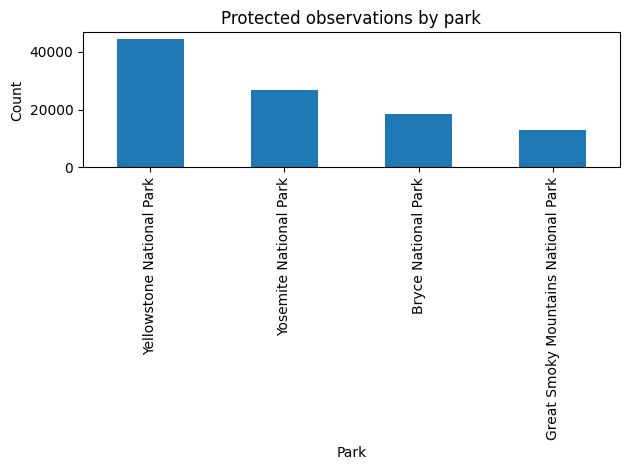

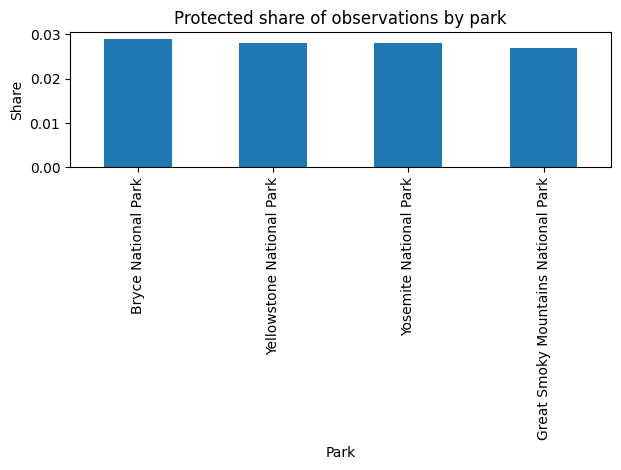

In [8]:
import matplotlib.pyplot as plt

# a) liczba obserwacji chronionych na park
park_summary[True].sort_values(ascending=False).plot(kind="bar")
plt.title("Protected observations by park")
plt.xlabel("Park")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# b) udział chronionych obserwacji na park
park_summary["protected_share"].sort_values(ascending=False).plot(kind="bar")
plt.title("Protected share of observations by park")
plt.xlabel("Park")
plt.ylabel("Share")
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

# 1) Wczytanie danych
species = pd.read_csv("species_info.csv")
observations = pd.read_csv("observations.csv")

# 2) Szybki podgląd
print("species:", species.shape)
print("observations:", observations.shape)
display(species.head())
display(observations.head())

# 3) Walidacja nazw kolumn (uwaga: w tym zestawie mamy 'common_names' - liczba mnoga)
expected_species = {"category", "scientific_name", "common_names", "conservation_status"}
expected_obs = {"scientific_name", "park_name", "observations"}

print("Species columns:", set(species.columns))
print("Observations columns:", set(observations.columns))
print("Missing in species:", expected_species - set(species.columns))
print("Missing in observations:", expected_obs - set(observations.columns))


species: (5824, 4)
observations: (23296, 3)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


Species columns: {'category', 'common_names', 'conservation_status', 'scientific_name'}
Observations columns: {'scientific_name', 'observations', 'park_name'}
Missing in species: set()
Missing in observations: set()
